In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

from torch.utils.tensorboard import SummaryWriter

import re
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


import spacy
import nltk
# from nltk.corpus import stopwords, wordnet
# nltk.download('wordnet')
# nltk.download('stopwords')

import random
import os, pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score

## Load Tweets Dataset

In [ ]:
tweets = pd.read_csv('/content/session6/tweets.csv', encoding = 'latin-1')

In [ ]:
tweets.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
tweets.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

[Text(0.5, 0, 'Labels')]

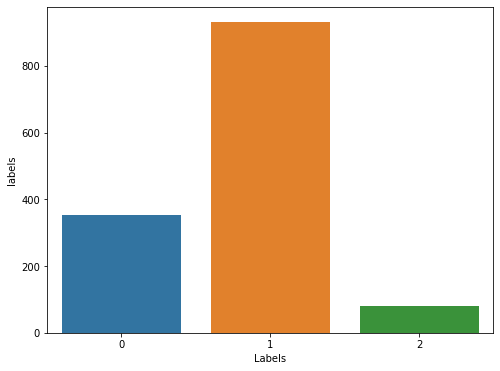

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=tweets['labels'].unique(), y=tweets['labels'].value_counts())

ax.set(xlabel = 'Labels')

### Data is imbalanced and should be made balanced

## Data cleanup, Train Test Split and prepare Vocab

In [ ]:
train, test = train_test_split(tweets, test_size= .2, random_state= 42)

In [ ]:
train.reset_index(drop=True), test.reset_index(drop=True)

(                                                 tweets  labels
 0     I'm Michelle Obama, u Kim K, C'mon bitch u see...       0
 1     LOOOOOOOOOOOOOOOOOOOOOOOOOOOOL This is why i r...       0
 2     RT @WhatTheFFacts: In his teen years, Obama ha...       0
 3     President Obama * Lindsay Lohan RUMORS video s...       0
 4     Barack Obama LONGBOARD Package CORE 7" TRUCKS ...       0
 ...                                                 ...     ...
 1086  #WhatsRomneyHiding Obama released his tax retu...       0
 1087                #KimKardashiansNextBoyFriend Obama!       0
 1088  RT @larryeldershow: Spike Lee said he dislikes...       0
 1089  RT @pourmecoffee: White House Easter Egg Roll ...       1
 1090  #WhatsRomneyHiding His relationship with Vera ...       0
 
 [1091 rows x 2 columns],
                                                 tweets  labels
 0    RT @ohgirlphrase: American kid "You're from th...       0
 1    Examiner Editorial: Obama's budget, not Ryan's...       0


In [ ]:
def tweet_clean(text):
  text = re.sub(r'[^A-Za-z0-9_-]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)

  return(text.strip())

In [ ]:
nlp = spacy.load('en', disable = ['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(tweet_clean(s))]

In [ ]:
TEXT = torchtext.legacy.data.Field(tokenize=tokenizer, lower=True, init_token= '<sos>', eos_token= '<eos>')

LABEL = torchtext.legacy.data.LabelField(tokenize = tokenizer)

# english = torchtext.legacy.data.Field(tokenize=tokenizer_end, lower=True, init_token= '<sos>', eos_token= '<eos>')

In [ ]:
datafields = [('tweets', TEXT), ('labels', LABEL)]

### Split and save datasets

In [ ]:
train.to_csv('session6/train.csv', index=False)
test.to_csv('session6/test.csv', index=False)

In [ ]:
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='/content/session6',
                                                       train = 'train.csv',
                                                       test = 'test.csv',
                                                       format = 'csv',
                                                       skip_header = True,
                                                       fields = datafields
                                                       )

In [ ]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 1091
Number of testing examples: 273


In [ ]:
vars(trn.examples[0])

{'labels': '0',
 'tweets': ['i',
  'm',
  'michelle',
  'obama',
  'u',
  'kim',
  'k',
  'c',
  'mon',
  'bitch',
  'u',
  'see',
  'where',
  'the',
  'black',
  'president',
  'at']}

In [ ]:
TEXT.build_vocab(trn, max_size = 10000,
                #  vectors = "glove.6B.100d",
                min_freq = 2 
                )

LABEL.build_vocab(trn) 

In [ ]:
print(TEXT.vocab.freqs.most_common(50))

[('obama', 1095), ('the', 552), ('rt', 496), ('t', 455), ('to', 394), ('co', 390), ('http', 388), ('s', 309), ('you', 285), ('a', 250), ('of', 234), ('is', 230), ('with', 205), ('in', 201), ('-', 181), ('do', 178), ('on', 165), ('and', 164), ('that', 164), ('i', 160), ('he', 157), ('kid', 145), ('for', 139), ('whatsromneyhiding', 135), ('his', 129), ('so', 126), ('like', 125), ('from', 117), ('president', 102), ('romney', 100), ('have', 99), ('it', 94), ('go', 91), ('not', 86), ('re', 85), ('at', 82), ('american', 79), ('cool', 77), ('has', 76), ('can', 75), ('uk', 72), ('ohhh', 72), ('tea', 72), ('queen', 72), ('british', 72), ('mcdonalds', 72), ('gop', 70), ('we', 69), ('ohgirlphrase', 68), ('tcot', 67)]


In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '<sos>', '<eos>', 'obama', 'the', 'rt', 't', 'to', 'co']


In [ ]:
print(LABEL.vocab.itos)

['0', '1', '2']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1, '2': 2})


## Build Model class

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.LSTM(embedding_size, hidden_size)
    # self.dropout = nn.Dropout(p_do)

  def forward(self,x):
    # x shape: (seq_length, N)
    embedding = self.embedding(x)

    # embedding shape: (seq_length, N, embedding_size)
    output, (hidden, cell) = self.rnn(embedding)

    print(f'encoder {output.shape}, {hidden.shape}, {cell.shape}')
    # output = 
    return output, hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, c_state_size, output_size):
      super(Decoder, self).__init__()

      self.rnn = nn.LSTM(input_size, hidden_size)
      self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
      # shape of x: (N) but we want (1,N)
      x = x.unsqueeze(0) 

      # embedding = self.dropout(self.embedding(x))
      # embedding shape will be (1, N, embedding_size)


      print(f'decoder {x.shape}, {hidden.shape}, {cell.shape}')
      outputs, (hidden, cell) = self.rnn(x.squeeze(0),(hidden, cell)) 
      print(f'decder output,hidden and cell shape {outputs.shape}, {hidden.shape}, {cell.shape}')

      # shape of outputs: (1, N, hidden_size)

      predictions = self.fc(outputs)
      print(f'prediction in decoder: {predictions.shape}')
      # shape of predictoin: (1,N, length_of_vocab)

      # predictions = predictions.squeeze(0)

      return predictions, hidden, cell


class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target):
    print(f'seq 2 seq {source.shape} target {target.shape}')
    batch_size = source.shape[1]    # (source_len, N)
    target_len = target.shape[0]    # (target_len)
    target_vocab_size = len(LABEL.vocab)

    # outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    op, hidden, cell = self.encoder(source)

    # Grab start token
    x = op

    predictions, d_hidden, d_cell = self.decoder(x, hidden, cell)

    predictions = predictions[]
    print(predictions.shape)
    best_pred= predictions.argmax()

    return best_pred


### Initialize Training Parameters

---



In [ ]:
## Training starts -

# Training hyperparameters
num_epochs = 1
learning_rate = 0.001
batch_size = 8

# Model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(TEXT.vocab)
input_size_decoder = 256 # Hidden dimention for output
output_size = len(LABEL.vocab)
encoder_embedding_size = 100

cell_state_size = 256
hidden_size = 256
num_layers = 1

# # Tensorboard
# writer = SummaryWriter(f'runs/loss_plot')
# step = 0

## Create Data Loaders

In [ ]:
# Get iterators
train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (trn, tst),
    batch_size = batch_size,
    sort_within_batch = True,
    sort_key = lambda x: len(x.tweets),
    device= device)


## Initialize Models, Optimizer and define Criterion

In [ ]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, 
                      hidden_size).to(device)

decoder_net = Decoder(input_size_decoder, hidden_size, cell_state_size, output_size).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)


optimizer = optim.Adam(model.parameters(), lr = learning_rate)

pad_idx = TEXT.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
for epoch in range(num_epochs):
  print(f'Epoch [{epoch} / {num_epochs}]')

  for batch_idx, batch in enumerate(train_iterator):
    inp_data = batch.tweets.to(device)
    target = batch.labels.to(device)

    output = model(inp_data, target)
    # output shape: target_len, batch_size, output_dim
    print(f"output {output}, target {target}")
    # output = output[1:].reshape(-1, output.shape[2])
    # target = target[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output, target)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    writer.add_scalar('Training Loss', loss, global_step=step)
    step += 1


Epoch [0 / 1]
seq 2 seq torch.Size([23, 8]) target torch.Size([8])
encoder torch.Size([23, 8, 256]), torch.Size([1, 8, 256]), torch.Size([1, 8, 256])
decoder torch.Size([1, 23, 8, 256]), torch.Size([1, 8, 256]), torch.Size([1, 8, 256])
decder output,hidden and cell shape torch.Size([23, 8, 256]), torch.Size([1, 8, 256]), torch.Size([1, 8, 256])
prediction in decoder: torch.Size([23, 8, 3])
torch.Size([23, 8, 3])
output 71, target tensor([0, 0, 1, 1, 0, 0, 0, 0])


IndexError: ignored

In [ ]:
m = nn.Linear(256, 3)
input = torch.randn(23, 8, 256)
output = m(input)
print(output.size())

torch.Size([23, 8, 3])
